# Trabalho Computacional 2. Perceptron Multicamada no problema MNIST

## 1. Introdução e Preparação

Faremos uso do MLP para o problema de classificação de dígitos manuscritos MNIST. O código apresentado nestas instruções devem ser visto como sugestão, mas o trabalho deve necessariamente estar em python, na forma de um "notebook", e implementar o perceptron multicamada com as características dadas para resolver o problema dado. 

Além das sugestões dadas aqui, observe o caderno de implementação do MLP no problema Fashion_MNIST que estudamos em sala. 

Começamos com os módulos necessários:

Pedro Eduardo Cunha Ximenes - 200026071
Miguel Mendes Luna - 211026501

In [2]:
import tensorflow as tf
import platform
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2024-05-24 00:20:34.383932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 00:20:34.409096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 00:20:34.409408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 00:20:35.025720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Não é necessário desta vez usar um arquivo em disco, porque a base de dados MNIST está disponível como um dos conjuntos de dados do submódulo `keras.datasets` do módulo `tensorflow`. 



In [2]:
class MNIST(d2l.DataModule):  #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

Há 60000 exemplos de treinamento e 10000 de validação. A entrada, em cada exemplo, é uma matriz 28x28 de pixels. As imagens originais manuscritas foram pré-processadas (normalizadas em tamanho e centralizadas). 

In [3]:
data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


Abaixo um código, do d2l, para ler um minibatch de um dado tamanho. Em cada chamada, ele nos dá o tensor de entrada X e a classe desejada y. 
Ele também embaralha os dados no momento do treinamento. Finalmente, observe que ele divide os valores de pixels por 255, para obter um `float` entre 0 e 1. 



In [4]:
@d2l.add_to_class(MNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(
        self.batch_size).shuffle(shuffle_buf)

Vamos usar isso com um minibatch e ver as dimensões

In [5]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

2024-05-23 23:54:06.212486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2024-05-23 23:54:06.212685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [60000]
	 [[{{node Placeholder/_1}}]]


(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


Você pode estranhar a princípio as dimensões de X. São 64 imagens 28x28, mas por que a dimensão unitária adicional? Lembre-se que, em geral, imagens têm 3 canais de cor. Estas imagens são em tons de cinza. 

## 2. Modelos e Arquiteturas

Para a implementação, baseie-se na classe MLP definida no caderno que vimos em sala de aula. A primeira camada deve ser do tipo "Flatten" como no outro exemplo. Ela transforma a matriz 28x28 em um vetor unidimensional de tamanho 784. Neste trabalho, vocês farão algumas variações de arquitetura, funções de ativação e algoritmos de treinamento, indo das técnicas usadas nas primeiras aplicações do Perceptron nos anos 80/90 às atuais. Para cada uma delas, avalie a acurácia, sobre o arquivo de validação, do modelo treinado. Você pode usar a função `test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())`. 

Eu não estou sugerindo que cada modificação introduzida vai necessariamente melhorar o modelo em todas as ocasiões. Lembre-se, também, que um valor melhor em um único treinamento pode não ter significância estatística. **Haverá bonificação se essas análises foram feitas para mais de uma rodada de treinamento (com valores de inicialização aleatória diferentes).** 

In [6]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs)])

### 2a) Perceptron com uma camada escondida, função de ativação sigmoide e otimização por descida de gradiente.

Comecemos com um MLP com uma camada escondida de 128 neurônios. Usaremos sigmoides na camada escondida e softmax na camada de saída. Passe o parâmetro `activation='sigmoid'` na função que cria a camada oculta e não precisa passar parâmetro para a camada de saída, pois ela já aplica o softmax na implementação da função de custo de entropia cruzada, como vimos em sala. Mantenha entropia cruzada como função de custo e a descida simples de gradiente como otimizador. 

In [7]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    Y = tf.reshape(Y, (-1,))
    fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return fn(Y, Y_hat)

In [8]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    if platform.system() == "Darwin" and platform.processor() == "arm":
        return tf.keras.optimizers.legacy.SGD(self.lr)
    else:
        return tf.keras.optimizers.SGD(self.lr)

2024-05-23 23:55:24.035156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-05-23 23:55:24.035371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


Final validation accuracy:  0.9455


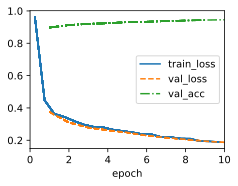

In [9]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', d2l.evaluate_accuracy(model, data.val_dataloader()));

### 2b) Otimizador Adam

O gradiente simples tem um inconveniente grave: sabemos que melhoramos o desempenho do classificador se acompanharmos o gradiente em um "pequeno passo", mas não é fácil determinar que passo deveria ser esse. E sabemos que ele deveria variar ao longo do treinamento. Várias propostas para uma adaptação da taxa de aprendizado foram feitas, mas a que acabou se tornando padrão é o chamado otimizador Adam (Kingma and Ba, 2014). O nome vem de "Estimativa adaptativa de momentos". Acompanhando a média e variância do gradiente entre atualizações, ele consegue adaptar a taxa de aprendizado, e torná-la diferente para cada parâmetro. 

Redefina a função `configure_optimizers` dentro da classe `MLP` e nela use agora `tf.keras.optimizers.Adam` como o otimizador. Retreine e reavalie.

In [10]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    if platform.system() == "Darwin" and platform.processor() == "arm":
        return tf.keras.optimizers.legacy.Adam(self.lr)
    else:
        return tf.keras.optimizers.Adam(self.lr)

KeyboardInterrupt: 

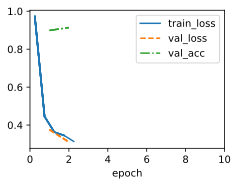

In [11]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', d2l.evaluate_accuracy(model, data.val_dataloader()))

### 

2c) A função Relu

Um desenvolvimento um tanto surpreendente foi a descoberta de que uma simples função retificadora (0 se a soma é negativa, função identidade se é positiva) nos dá não-linearidade suficiente para o MLP. Use na camada oculta `activation='relu'`. Retreine e reavalie.

In [12]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs)])

2024-05-23 23:31:59.375365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-05-23 23:31:59.375627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


Final validation accuracy:  0.6671


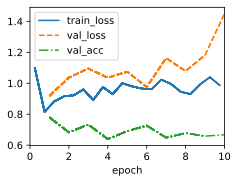

In [13]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', d2l.evaluate_accuracy(model, data.val_dataloader()))

 

### 2d) Redes maiores

Com esses desenvolvimentos, e a melhoria geral na capacidade de computação, aos poucos foi possível trabalhar com redes cada vez maiores. Experimente uma camada escondida com 256 neurônios, e também uma rede com duas camadas escondidas. Retreine e reavalie. 

2024-05-23 20:38:43.862738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-05-23 20:38:43.862988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


Final validation accuracy:  0.5905


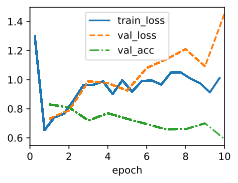

In [15]:
#256 neurônios
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', d2l.evaluate_accuracy(model, data.val_dataloader()))

2024-05-23 23:34:46.912168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-05-23 23:34:46.912373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


Final validation accuracy:  0.5295


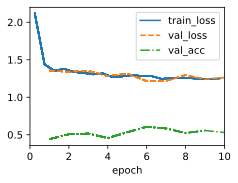

In [17]:
class MLP_2_hidden_layers(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, num_hiddens_2, lr):   #Adicionando o número de neurônios da segunda camada
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_hiddens_2, activation='relu'),   #Adicionando segunda camada
            tf.keras.layers.Dense(num_outputs)])

model = MLP_2_hidden_layers(num_outputs=10, num_hiddens=256, num_hiddens_2=256, lr=0.1)
triner = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', d2l.evaluate_accuracy(model, data.val_dataloader()))

## 3. Visualização 

Gostaríamos agora de observar alguns dos exemplos mal-classificados. Você pode se basear na função `data.visualize` do exemplo visto em sala, mas adaptações são necessárias. Em primeiro lugar, naquela ocasião usamos apenas os erros de um minibatch. Como o desempenho daquele classificador foi relativamente fraco, havia erros em todos os "minibatches". O MLP (especialmente os maiores) deve ter um número pequeno de erros, e é possível que não haja nenhuma classificação errada em um dado minibatch. Isso produziria um erro no seu código.  

Além disso, queremos talvez visualizar o erro não apenas no último minibatch. Faça um código que passe por todos os minibatches (por exemplo, `for X, y in data.val_dataloader()`) e identifique exemplos de classificações incorretas. Ou então, trabalhe diretamente com o objeto MNIST "data". Neste caso, lembre-se que data.train e data.val são ambas "duplas", contendo as entradas e as saídas de todos os exemplos.  Usar o iterador como `data.val_dataloader()` torna-se essencial quando usarmos grandes bases de dados e não pudermos trazer e alocar tudo em memória de uma vez.

Há um outro problema na implementação feita em sala. `data.visualize` espera uma lista de imagens, e não vai funcionar com uma imagem única. Assim como pode haver minibatches sem erros, pode haver minibatches com um erro a visualizar apenas. Nestes casos talvez as funções `imshow` e `show` do módulo `matplotlib.pyplot` possam ser úteis. 

Seja como for, mostre alguns padrões erradamente classificados (juntamente com os rótulos esperados e obtidos, como vimos no exemplo em sala de aula). Você acha que é razoável que um humano cometesse esse tipo de erro? 

In [38]:
def showSingleImage(image, title: str = "Sem Título"):
    plt.figure(figsize=(7, 4))
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [39]:
def showMultipleImages(imgsArray, titlesArray, size, x, y):
    if(x < 1 or y < 1):
        print("ERRO: X e Y não podem ser zero ou abaixo de zero!")
        return
    elif(x == 1 and y == 1):
        showSingleImage(imgsArray, titlesArray)
    elif(x == 1):
        fig, axis = plt.subplots(y, figsize = size)
        yId = 0
        for img in imgsArray:
            axis[yId].imshow(img)
            axis[yId].set_anchor('NW')
            axis[yId].set_title(titlesArray[yId], fontdict = {'fontsize': 10, 'fontweight': 'medium'}, pad = 10)

            yId += 1
    elif(y == 1):
        fig, axis = plt.subplots(1, x, figsize = size)
        fig.suptitle(titlesArray)
        xId = 0
        for img in imgsArray:
            axis[xId].imshow(img)
            axis[xId].set_anchor('NW')
            axis[xId].set_title(titlesArray[xId], fontdict = {'fontsize': 10, 'fontweight': 'medium'}, pad = 10)

            xId += 1
    else:
        fig, axis = plt.subplots(y, x, figsize = size)
        xId, yId, titleId = 0, 0, 0
        for img in imgsArray:
            axis[yId, xId].set_title(titlesArray[titleId], fontdict = {'fontsize': 10, 'fontweight': 'medium'}, pad = 10)
            axis[yId, xId].set_anchor('NW')
            axis[yId, xId].imshow(img)
            if(len(titlesArray[titleId]) == 0):
                axis[yId, xId].axis('off')

            titleId += 1
            xId += 1
            if xId == x:
                xId = 0
                yId += 1
    plt.show()

In [41]:
@d2l.add_to_class(MNIST)  #@save
def visualize(self, data, nrows=1, ncols=8, labels=["oi"]):
    for X, y in data.val_dataloader():
        preds = tf.argmax(model(X), axis=1)

        wrong = tf.cast(preds, y.dtype) != y
        X, y, preds = X[wrong], y[wrong], preds[wrong]
        print(y)
        print(len(y))
        labels = [f"{a}\n{b}" for a, b in zip(
            y.numpy().tolist(), preds.numpy().tolist())]
        print(labels)
        

        # d2l.show_images(tf.squeeze(X), nrows, len(y), labels)
        showMultipleImages(tf.squeeze(X), labels, (len(y)*3, 5), len(y), 1)

In [1]:
data.visualize(data)

NameError: name 'data' is not defined

In [45]:
X, y = next(iter(data.val_dataloader()))
preds = tf.argmax(model(X), axis=1)

2024-05-24 00:19:58.812851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2024-05-24 00:19:58.813040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


['5\n6', '4\n6']


array([<Axes: title={'center': '5\n6'}>, <Axes: title={'center': '4\n6'}>],
      dtype=object)

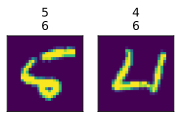

In [46]:
wrong = tf.cast(preds, y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
# print(len(y.numpy().tolist()))
# print(preds.numpy().tolist())
# print(tf.squeeze(X))
labels = [f"{a}\n{b}" for a, b in zip(
    y.numpy().tolist(), preds.numpy().tolist())]

print(labels)
# data.visualize([X, y], labels=labels)
d2l.show_images(tf.squeeze(X), 1, len(y), labels)

## 4. Matriz de confusão

Queremos agora observar a matriz de confusão do seu melhor classificador. A função `confusion_matrix` do módulo `sklearn.metrics` faz esse cálculo, mas temos de novo o problema que essa função espera receber todos as classes corretas (`y`) e todas as predições (`preds`) de uma vez. De novo, faça isso para cada minibatch usando o iterador ``data.val_dataloader()`` e depois combine-as corretamente, ou então trabalhe diretamente com as duplas no objeto data. 

Obtenha a matriz de confusão (10x10). Observe o resultado. Quais são as "confusões" mais comuns para cada classe (ou seja, para cada classe i qual a classe j é a atribuição errada mais comum? Isso faz sentido?

